In [58]:
import jax.numpy as jnp
import jax
import bayes3d as b
import pathlib
import matplotlib.pyplot as plt
import genjax
from jax.scipy.spatial.transform import Rotation
from bayes3d.genjax.genjax_distributions import UniformPose


# A gentle introduction to GenJAX with Bayes3D

This notebook is an introduction to the world of probabilistic programming, specifically, the [Gen](https://github.com/opengen) flavor of programming pioneered by the [MIT Probabilistic Computing Laboratory](http://probcomp.csail.mit.edu). Gen provides a "rational engine" which can be used to quickly evaluate _proposals_ about the state of a system and then to guide the search toward ever more probable explanations. Bayes3D is a system designed to provide a GPU-accelerated method of this evaluation step in the context of machine vision, and GenJAX provides GPU acceleration for the nongraphic update part.

We'll begin this investigation with an ordinary coffee cup. We'll choose a position and orientation of the cup, and keep that information to ourselves. We will then inquire whether the machine can tell where the cup is just by looking at it.

## Some preliminaries

We begin by loading the cup model. Bayes3D has its own mesh loader, so we will initialize it with some camera parameters and then load the cup model (#13 in the [BOP collection](https://bop.felk.cvut.cz/datasets/) of test models).

In [59]:
b.utils.get_assets_dir()

'/home/colin/bayes3d/assets'

In [60]:
b.setup_renderer(b.Intrinsics(height=100, width=100, fx=150.0, fy=150.0, cx=50.0, cy=50.0, near=0.001, far=6.0))
assets = pathlib.Path(b.utils.get_assets_dir())
sample_dir = assets / "sample_objs"
model_dir = assets / "bop/ycbv/models"

def load_model(k, scaling_factor=8e-4):
    b.RENDERER.add_mesh_from_file(model_dir / f"obj_{k+1:06}.ply", scaling_factor=scaling_factor)

load_model(13)
cup = b.RENDERER.meshes[0].vertices

Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Here's a visualization of the vertex cloud of the cup model:

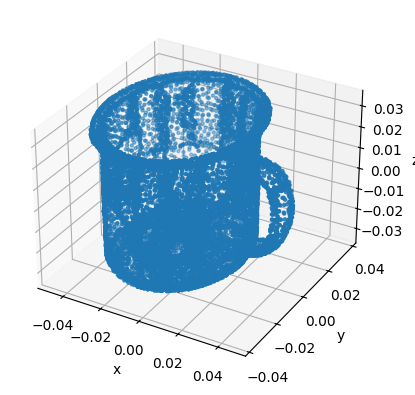

In [61]:
def viz():
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(cup[:,0], cup[:,1], cup[:,2], marker='.')
    ax.set_xlabel('x'); ax.set_ylabel('y'), ax.set_zlabel('z')

viz()

## The Pose Matrix

Now that we have an object, we'd like to situate it in space. You could imaging moving the cup in space to a some location in a room, and then rotating it. The position and orientation of an object is called its _pose_. 

The vertices of the cup model are arranged in the form of a two dimensional array: one row for each point, and 3 columns for x, y, and z. Suppose we want to rotate the cup 180º, so that the handle will appear on the right instead of the left. Looking at the plot, we can see that the cup is sitting on the $xy$ plane, with the $z$ axis going up through the center of the cup. So we want a rotation around the Z axis. Such a rotation can be represented by a _rotation matrix_:  

In [62]:
M = Rotation.from_euler('z', jnp.array([180]), True).as_matrix()
M

Array([[-1.000000e+00,  8.742278e-08,  0.000000e+00],
       [-8.742278e-08, -1.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00]], dtype=float32)

Our task now is to multiply each row of the object by this matrix to accomplish the rotation of the entire body. The rotation matrix is 3x3; the vertices are Nx3. We can transpose the points into a 3xN matrix; then the standard matrix product will give is a 3xN result: (3x3 @ 3xN -> 3xN). This is transposed from what he had initially. (We could transpose it back, but we find that this form is convenient since `ax.scatter` wants to be called with individual vectors of $x, y$ and $z$ coordinates, and now we have exactly these in the three rows of our result). Let's write a function to put this together.

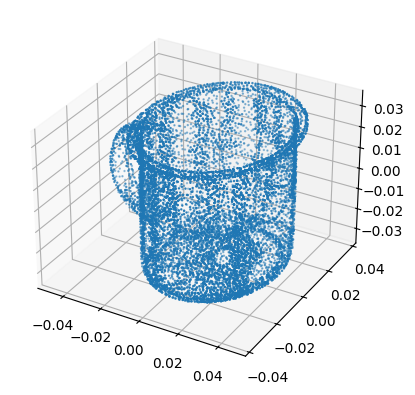

In [63]:
def viz_model(ax, model, M=jnp.eye(3)):
    Mv = M @ model.T
    ax.scatter(Mv[0], Mv[1], Mv[2], marker='o', s=(72./fig.dpi)**2)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
viz_model(ax, cup, M)

To change the size of the cup, we can _scale_ it. This just means multiplying each of the coordinates by a scaling constant: $>1$ to expand it and $<1$ to shrink it. It turns out a diagonal matrix will have this effect. (We could operate directly on the points; we could even multiply the whole vertices array by the constant efficiently using [brodcasting arithmetic](https://numpy.org/doc/stable/user/basics.broadcasting.html), but we prefer to use a diagonal matrix because it _composes_ (via matrix multiplication) with the other transformations we will make, so at the end, we will have one matrix that does the whole job. `Eye` is the numpy name for the identity matrix, which we might call the "unit scale matrix" in this application. If we multiply it by M, we will find that cup is rotated and scaled in one step:

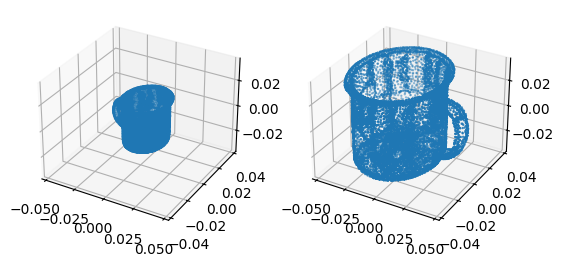

In [64]:
S = jnp.eye(3) * 0.5
fig = plt.figure()
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax1 = fig.add_subplot(1, 2, 2, projection='3d', sharex=ax0, sharey=ax0, sharez=ax0)
viz_model(ax0, cup, S @ M)
viz_model(ax1, cup)


The last piece of the puzzle is translation: moving the whole cup to another location, away from the origin. We can't use a 3x3 matrix for that, since translation is not _linear_ in the sense we use that term in linear algebra (for us, a linear transformation must carry the zero vector to the zero vector). We fix this by adding a dummy coordinate to our point vectors so that our transformation matrix becomes a 4x4 matrix. This gives us the freedom to encode a rotation, scaling, and translation all in the same matrix. (We could also do shear and reflection, but since those transformations aren't "physical" we won't worry about them in this notebook).

The 4x4 matrix is constructed this way. The rotation/scaling part of the matrix is in the upper-left 3x3 submatrix. The destination we want to translate to is in the right hand column (first three entries), and the bottom row is always [0,0,0,1]. A quick check shows, for example, that we can add 2 to the x and y coordinates, leaving everything else alone, like this: 

In [65]:
T = jnp.array([[1, 0, 0, 2],
               [0, 1, 0, 2],
               [0, 0, 1, 0],
               [0, 0, 0, 1]])
T @ jnp.array([1,2,3,1])

Array([3, 4, 3, 1], dtype=int32)

Notice the "translation" vector is vertically in the rightmost column, and the "identity transformation" is in the 3x3 submatrix in the upper left. Let's write a function that will couple a rotation/scale matrix and translation vector into this form:

In [66]:
def pose(M, T):
    return jnp.block([[M,                T.reshape((3,1))],
                      [jnp.zeros((1,3)), jnp.ones((1,1))]])

In [67]:
pose(jnp.eye(3), jnp.array([1,2,3]))

Array([[1., 0., 0., 1.],
       [0., 1., 0., 2.],
       [0., 0., 1., 3.],
       [0., 0., 0., 1.]], dtype=float32)

We will take this opportunity to update our cup model to convert add the fourth dummy $1$ coordinate to each point:

In [68]:
cup4 = jnp.insert(cup, 3, 1.0, 1)

# Creating Poses with a Generative Function

Now back to the question of pose estimation using Bayes3D. In the Gen paradigm, we begin with a [generative function]() which can be _sampled_ to produce objects from a prior distribution which we represents what we know about what the ground truth could be. We will begin by considering a random pose within a cubical region, where any pose is just as likely as any other. Bayes3D provides a distribution for this purpose called `UniformPose`. Now we will create one of these objects and visualize a sample drawn from it. The arguments of the pose generator can be thought of as two "corners" in 3D space; the pose position will lie in the cube spanned by the corners, and the rotation will be chosen independently. 

Drawing from a random variable requires a source of randomness. The standard technique in GenJAX is to use a splittable random number generator, keeping the left fork of the generator throughout the notebook and handing the right fork to each function that needs randomness. This allows for a reproducible notebook, provided the generator is initialized with a fixed seed and all the cells are evaluated in order.

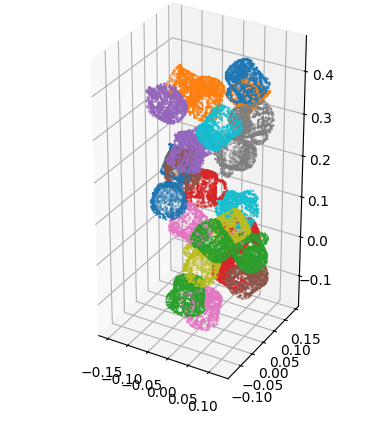

In [69]:
key = jax.random.PRNGKey(0)

pose_generator = b.UniformPose()
pose_bounds = jnp.array([-0.1,-0.1,-0.1]), jnp.array([0.1,0.1,0.4])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
def pose_samples(ax, key, generator: genjax.ExactDensity, gen_args, n_samples):
    keys = jax.random.split(key, n_samples)
    poses = (generator.sample(k, *gen_args) for k in keys)
    for P in poses:
        # We use [::16] as a cheap way to "downsample" the cup model, which speeds up the figure generation
        viz_model(ax, cup4[::16], P)
    ax.set_aspect('equal')

key, sub_key = jax.random.split(key)
pose_samples(ax, sub_key, pose_generator, pose_bounds, 25)

As you can see, this is about what we would expect from a uniformly random pose, given we assume nothing about the cup's position. Now we will select one particular pose for inference:

In [70]:
key, sub_key = jax.random.split(key)
target_pose = pose_generator.sample(sub_key, *pose_bounds)

## How does Bayes3D inference work?

Bayes3D contains a custom GPU-accelerated rendering function that acts like a virtual _depth camera_. Rather than produce an RGB color image with lighting, shadows, and other visual effects, the Bayes3D render produces a depth map. Just as in the polynomial evaluation demo for GenJAX, we will use a ChoiceMap to fix the ground truth, and let the _model parameters_ vary. Bayes3D will draw samples from the pose distribution, compute depth images, and then compare those images to the depth image of the ground truth to determine the _likelihood_ that the sampled model parameters could explain the depth image we have supplied. Using the GPU acceleration in JAX, we can do thousands of such comparisons in parallel. Each such comparison results in a log-likelihood score. The code that does the likelihood computation is `image_likelihood`, itself a generative function, with an _importance_ method that scores the proposal. We will prepare a function that uses Bayes3D's internal GPU renderer to produce a _depth image_ of the cup in a given pose.

In [71]:
@genjax.static
def simple_model(pose_gf, low, high):
    """`low` and `high` are the corners of a cube in the view volume that bound
    generated poses. The Bayes3D renderer will generate a depth image corresponding
    to the pose, and image_likelihood will score the rendered image against the
    image in the choicemap."""
    pose = pose_gf(low, high) @ "pose"
    rendered = b.RENDERER.render(pose[None,...], jnp.array([0]))
    rendered = rendered[...,:3]
    variance = genjax.uniform(1e-11, 10000.0) @ "variance"
    return b.image_likelihood(rendered, variance, 0) @ "image"
simple_model_jit = jax.jit(simple_model.importance)


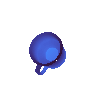

In [72]:

model_args = (pose_generator, *pose_bounds)
key, sub_key = jax.random.split(key)
trace, weight = simple_model_jit(sub_key, genjax.choice_map({"pose": target_pose}), model_args)
obs_image = trace["image"]
b.get_depth_image(obs_image, max_val=0.8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


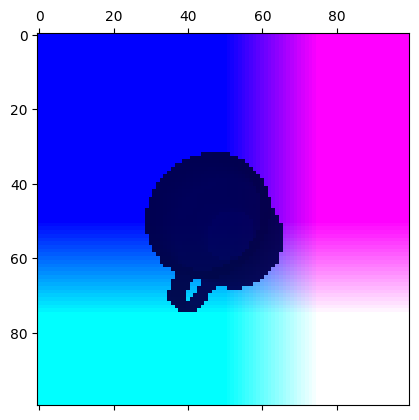

In [73]:
plt.matshow(obs_image)

Now we will conceal the pose data from Bayes3D, and instead supply the depth image of the ground truth. That means creating a choice map where the `pose` field is unconstrained, but the image is the value we just observed. This is effectively changing from the forward problem, where we dictated the pose of the cup and rendered it, to the inverse problem: estimating the pose of the cup given the depth camera information. In the Gen model of probabilistic computing, nothing needs to change except the choice map:
- forward problem: `{"pose": target_pose}`
- inverse problem: `{"image": obs_image}`

In [74]:
def importance_sample(key, chm):
    trace, weight = simple_model_jit(key, chm, model_args)
    return trace["pose"], trace.get_score()
importance_sample_vmap = jax.jit(jax.vmap(importance_sample, in_axes=(0, None)))

`jit` and `vmap` are the two fundamental operations of JAX acceleration. `vmap` prepares a function to execute in parallel, and `jit` compiles it into an internal representation suitable for compilation into GPU machine instructions. Functions treated in this way must satisfy certain constraints, and the GenJAX library takes care that generative functions assembled using the library functions and combinators have the necessary properties. The experiments in this notebook use features (such as UniformPose) directly from the library, so we don't have to write any JAX-compatible code ourselves. The technique of using combinators to create JAX-compatible generative functions with loops and control flow is an interesting topic discussed in other notebooks in this series.

Having made the preparations, we use `importance_sample` to prepare a large number of scored poses. 

5.727832 5.727832


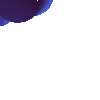

In [75]:
N = 10000
key, sub_key = jax.random.split(key)
poses, weights = importance_sample_vmap(jax.random.split(sub_key, N), genjax.choice_map({"image": obs_image}))
print(weights.max(), weights.max())
trace, weight = simple_model_jit(sub_key, genjax.choice_map({"pose": poses[weights.argmax()]}), model_args)
#b.get_depth_image(b.get_rendered_image(trace), max_val=0.8)
b.get_depth_image(trace["image"], max_val=0.8)

The last image was a depth image created from the pose sample in the distribution that received the highest score from the `ImageLikelihood` model. Typically we find that the position has been identified fairly accurately but the orientation is quite approximate. The _importance sampling_ technique we have used is just the beginning of the Bayesian inference of which Bayes3D is capable. We also note that the array of candidate poses and scores can be treated as categorical distribution with weights. We can arrange to take a weighted sample of these results, a technique known as _sampling the posterior_. 

To do this, we will create a generative function built out of the weighted categorical distribution we have inferred above, and draw some samples from it. These samples will come in the form of indices into the weights table, and then we will render the corresponding poses.

In [76]:
n_pose_samples = 25

@genjax.static
def posterior():
    return genjax.categorical(weights) @ "p"

keys, *sub_keys = jax.random.split(key, n_pose_samples + 1)
pose_indices = jnp.array([posterior.simulate(k, ()).get_retval() for k in sub_keys])

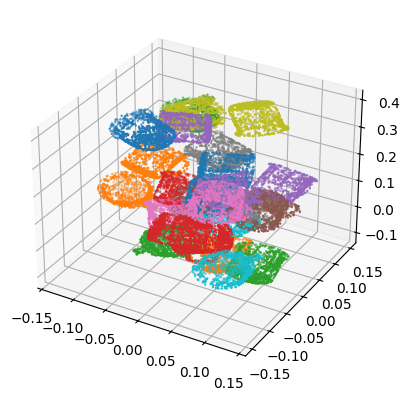

In [77]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in pose_indices:
    viz_model(ax, cup4[::16], poses[i])

<span style="color:red">TODO(colin): frankly, these poses look more or less random. I was hoping that doing a weighted sample would concentrate the selected poses around the actual cup position.  I wonder what could be done to improve things. Talk to Nishad about this.</span>

We can visualize the score distribution of the prior and posterior distributions, and see how our categorical selection is biased toward higher-scoring choices.

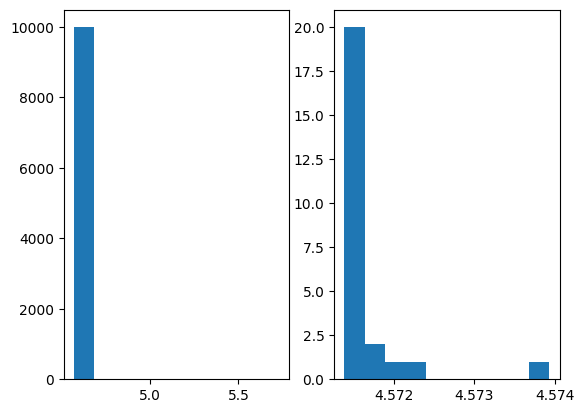

In [78]:
def compare_weight_distributions():
    fig = plt.figure()
    ax1, ax2 = fig.subplots(1, 2)
    ax1.hist(weights)
    ax2.hist(weights[pose_indices])

compare_weight_distributions()

## Simplifying the Problem Domain

We pause here to note that the importance sampling we have used is a simple technique: it's unreasonable to expect it to thoroughly search the six-dimensional pose space without more guidance. We could create more sensitive weighting tools than `ImageLikelihood`, which is in essence a norm of the difference of the depth-image matrices, but instead we will experiment with adding constraints to the problem.

Suppose, for example, that the cup is sitting upright on a tabletop. Now there are only three values to infer: the $(x, y)$ position on the table and the angle of rotation of the handle. We can create a new pose distribution that reflects these constraints.

In [79]:
# TODO(colin): I have subclassed UniformPose because I want to reuse its `logpdf` implementation.
# Would it work as well to just write a generative function that returns pose matrices? I would
# like that, but what would the difference in the logpdf behavior be?
#
# But `model` does not take a pose distribution argument, just a pose_bounds argument, so this
# approach won't work. Ask Nishad whether such a thing might be worth doing in bayes3d, or
# if it would be better to introduce the contact model (which I don't understand).

class TabletopPose(UniformPose):
    def sample(self, key, low, high):
        k1, k2 = jax.random.split(key, 2)
        T = (jax.random.uniform(k1, shape=(3,)) * (high - low) + low).at[2].set(0.3)
        R = Rotation.from_euler('xz', jnp.array([180, jax.random.uniform(k2) * 360.0]), degrees=True).as_matrix()
        return pose(R, T)

tabletop_pose = TabletopPose()


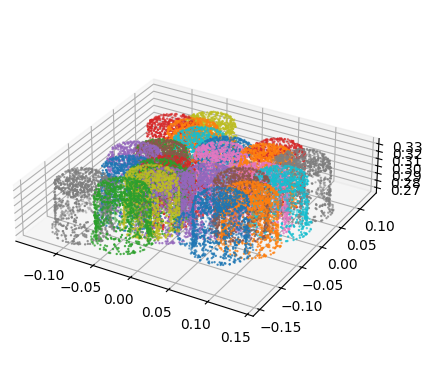

In [80]:
key, sub_key = jax.random.split(key)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
pose_samples(ax, sub_key, tabletop_pose, pose_bounds, 25)

That does appear to be a distribution of cups sitting on a flat surface. (In this notebook, the camera is at the origin and is looking toward the increasing $z$ axis. We flipped the cups "over", so that the camera will then appear to be looking down at the tabletop from above.) Now we select one of these:

[[-6.1898947e-01  7.8539932e-01 -6.8661791e-08  6.5295480e-02]
 [ 7.8539932e-01  6.1898947e-01 -5.4113769e-08  5.0594360e-03]
 [ 3.5527137e-15 -8.7422777e-08 -1.0000000e+00  3.0000001e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
13.781628


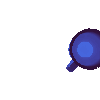

In [81]:
key, sub_key = jax.random.split(key)
table_target_pose = tabletop_pose.sample(sub_key, *pose_bounds)
table_model_args = (tabletop_pose, *pose_bounds)
# Generate the target image
def get_table_image(pose):
    trace, weight = simple_model_jit(sub_key, genjax.choice_map({"pose": pose}), table_model_args)
    return trace["image"], weight

table_image, table_weight = get_table_image(table_target_pose)
print(table_target_pose)
print(table_weight)
b.get_depth_image(table_image, max_val=0.8)

5.4217067


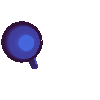

In [82]:
N = 10000

def table_importance_sample(key):
    trace, weight = simple_model_jit(key, genjax.choice_map({"image": table_image}), table_model_args)
    return trace["pose"], trace.get_score()
table_importance_sample_vmap = jax.jit(jax.vmap(table_importance_sample, in_axes=(0)))

key, sub_key = jax.random.split(key)
table_poses, table_weights = table_importance_sample_vmap(jax.random.split(sub_key, N))
print(table_weights.max())
inferred_image, _ = get_table_image(table_poses[table_weights.argmax()])
b.get_depth_image(inferred_image, max_val=0.8)

In [83]:
@genjax.static
def table_posterior():
    # TODO: make weights a parameter
    return genjax.categorical(table_weights) @ "p"

keys, *sub_keys = jax.random.split(key, n_pose_samples + 1)
table_pose_indices = jnp.array([posterior.simulate(k, ()).get_retval() for k in sub_keys])

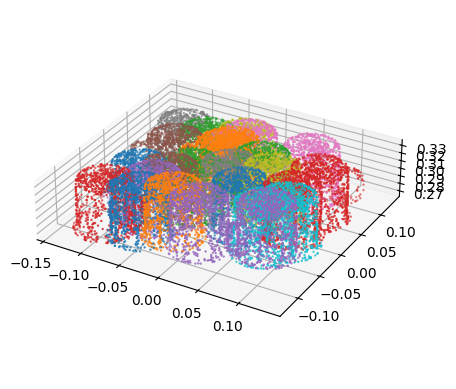

In [84]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in table_pose_indices:
    viz_model(ax, cup4[::16], table_poses[i])
ax.set_aspect('equal')